# Data Preprocessing Notebook

# Introduction

The initial dataset being sourced is from the HuggingFace library, (https://huggingface.co/datasets/brianarbuckle/cocktail_recipes)

This initial dataset contains columns `title`, `ingredients`, `directions`, `misc`, `source`, and `ner`.

**Overview**
The 'Ingredients' column of our dataset presents a unique challenge. It consists of objects, each being a list of strings, where each string details a part of a cocktail recipe. These details typically include the quantity, unit, and name of an ingredient, but they can also contain preparation instructions or garnishing details that are not directly usable in their current form for data analysis or recipe generation.

**Objective**
Our goal is to parse these strings to extract structured information that can be effectively utilized in our project. Specifically, we aim to separate the ingredient details into distinct components: quantity, unit, and ingredient name, while filtering out the non-ingredient related information.

## Imports

In [1]:
import pandas as pd
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

pip install datasets to access HuggingFace datasets library

In [2]:
#!pip install datasets

# Initial Data Inspection

In [3]:
# Loading the cocktail_recipes dataset
dataset = load_dataset('brianarbuckle/cocktail_recipes')

In [4]:
df = pd.DataFrame(dataset['train'])

In [5]:
df.head(5)

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        875 non-null    object
 1   ingredients  875 non-null    object
 2   directions   875 non-null    object
 3   misc         875 non-null    object
 4   source       875 non-null    object
 5   ner          875 non-null    object
dtypes: object(6)
memory usage: 41.1+ KB


In [7]:
df.shape

(875, 6)

From this **Initial Data Inspection**, we see that the data is a 875 x 6 dataframe, entirely of objects. We also get to see that there are multiple instances of entries being `[]` constiting non-null entries.

# Data Cleaning

Section involves removing empty rows, rows irrelevant to the analysis, or any rows unusable in the analysis.

In [8]:
# Removing rows where `ingredients` is empty
non_empty_ingredients_df = df[df['ingredients'].apply(lambda x: len(x) > 0)]
modified_df = non_empty_ingredients_df.reset_index(drop=True)

In [9]:
modified_df.shape

(873, 6)

From this, we can see that the dataframe went from 875 → 873 rows. So only two rows contained no information in the ingredients section. 

# Deleting problematic rows

In [10]:
# Check for any lists that only contain an empty string in the 'ingredients' column
lists_with_empty_string = modified_df['ingredients'].apply(lambda x: x == ['']).any()
print(f"Are there any lists with just an empty string in 'ingredients'? {lists_with_empty_string}")

Are there any lists with just an empty string in 'ingredients'? True


In [11]:
# Get rows where the 'ingredients' column contains lists with just an empty string
rows_with_empty_string_list = modified_df.loc[modified_df['ingredients'].apply(lambda x: x == [''])]

# Display these rows
rows_with_empty_string_list

,title,ingredients,directions,misc,source,ner
10,Agent Orange,[],[Shake the liquid ingredients vigorously with ...,[Suggested glassware is Cocktail Glass],,[]
55,Bay Breeze,[],[Pour the ingredients into an ice-filled highb...,[The Bay Breeze was made famous by Rachel McAd...,,[]


In [12]:
indices_to_drop = [7, 872,9,54] # drops rows, explanations below

#7: industrial size recipie 
#872: ontocord mimosa
# 9, 54:  `ingredients` were just empty strings [''] 

# Drop row from the DataFrame, Reset the index 
modified_df = modified_df.drop(index=indices_to_drop).reset_index(drop=True) 

# Parsing 'Ingredients'

This section will involve parsing the 'Ingredients' column in order to obtain data relevant to the project, and organize it such that it can be utilized.

For example, the current 'ingredients' column contains data such as:

In [13]:
modified_df['ingredients'][5]

['1.25 oz. Brandy',
 '0.5 oz. Amontillado Sherry',
 '0.5 oz. Lemon Juice',
 '1 Barspoon Lime Juice ',
 '0.5 oz. Demerara Syrup (2:1)',
 '1 oz. Water',
 'mix all ingredients and add ice',
 'Lemon slice and fresh grated nutmeg']

In [14]:
modified_df['ingredients'][841]

['2qts lager, 1qt rum, 5oz simple syrup, 3oz lemon juice, 1tsp nutmeg, 1tsp ginger, fruit']

In [15]:
'''  
There are rows where, for example, the `ingredients is`
['2qts lager, 1qt rum, 5oz simple syrup, 3oz lemon juice, 1tsp nutmeg, 1tsp ginger, fruit']
This function will split this into the intended format (the most of the dataframe is in of

['2qts lager',
 '1qt rum',
 '5oz simple syrup',
 '3oz lemon juice',
 '1tsp nutmeg',
 '1tsp ginger',
 'fruit']

 NOTE: This is done based on commas in the original sequence, so if it does not have any, it will remain a 1 step (0 index) length `ingredients`
'''
def split_combined_ingredients(ingredients_list):
    # Check if the list has only one item and if that item contains a comma
    if len(ingredients_list) == 1 and ',' in ingredients_list[0]:
        # Split the single string into multiple items based on ', '
        # Additionally, trim any excess whitespace around the newly split strings
        return [ingredient.strip() for ingredient in ingredients_list[0].split(', ')]
    else:
        # If the list is already in the expected format, return it as is
        return ingredients_list

# Apply the function to each row in the 'ingredients' column
modified_df['ingredients'] = modified_df['ingredients'].apply(split_combined_ingredients)

In [16]:
modified_df['ingredients'][841]

['2qts lager',
 '1qt rum',
 '5oz simple syrup',
 '3oz lemon juice',
 '1tsp nutmeg',
 '1tsp ginger',
 'fruit']

## Analysis

- **Ingredient Entries**: Most strings follow a common format: `[quantity] [unit] [ingredient]`, which allows for standardized extraction. For example, `1.5 oz. 151-Proof Demerara Rum [Lemon Hart or El Dorado]` contains clear quantity, unit, and ingredient name components.

- **Non-Ingredient Instructions**: Some strings contain instructions or garnishing details, such as `blend at high speed for 5 seconds, pour into metal cup or a pilsner glass`, which do not fit the standard ingredient format and are thus considered unusable for direct ingredient analysis.


## Strategy
To tackle this, we employ a parsing function that utilizes regular expressions to identify and extract the quantity, unit, and ingredient name from each string, while discarding any non-ingredient information. This function is designed to handle the common format efficiently and includes error handling for strings that do not conform to the expected pattern.

By parsing the 'Ingredients' column in this manner, we aim to create a structured and usable dataset that will serve as a solid foundation for the subsequent stages of our project, including data analysis and the generation of new cocktail recipes.

## Removing adjectives from the ingredients

Some items in the ingredients list of cocktails have adjectives such as "fresh". As a result, there are several items that, while stating the same ingredient, are considered unique. 

In [17]:
def parse_ingredient(ingredient_str, step_index):
    # Pre-process to correct known formatting issues
    corrected_str = re.sub(r'\\', '', ingredient_str)  # Remove backslashes that might interfere with parsing
    corrected_str = corrected_str.strip()
    
    # Lowercase all items in the ingredient list and remove "fresh"
    corrected_str = corrected_str.lower().replace('fresh', '').strip()
    
    pattern = re.compile(
        r'(?P<quantity>\d+\s*\d*\/\d+|\d*\.\d+|\d+)?\s*'  # Capture quantities, fractions, decimals
        r'(?P<unit>oz|ounces?|tsp|teaspoons?|tablespoons?|tbl|tbs|cups?|pints?|quarts?|gallons?|lbs?|pounds?|ml|mL|liters?|dash|dashes|drops?|pinch|pinches|qt|qts|cl)?\.?\s*' 
        r'(?P<ingredient>.+)', re.IGNORECASE)
    
    match = pattern.match(corrected_str)
    
    if match:
        # Normalize unit names
        unit = match.group('unit')
        if unit:
            unit = unit.lower()
            if unit in ['tsp', 'teaspoons']:
                unit = 'tsp'
            elif unit in ['tbl', 'tbs', 'tablespoons']:
                unit = 'tbsp'
            elif unit in ['pounds', 'pound', 'lbs']:
                unit = 'lb'
            elif unit in ['gallons', 'gallon']:
                unit = 'gal'
            elif unit in ['ounces', 'ounce', 'oz']:
                unit = 'oz'
            elif unit in ['milliliters', 'millilitre', 'ml', 'mL']:
                unit = 'ml'
            elif unit in ['liters', 'litre']:
                unit = 'l'
            elif unit in ['qt', 'qts']:  
                unit = 'qt'
        
        return {
            'quantity': match.group('quantity'), 
            'unit': unit, 
            'ingredient': match.group('ingredient').strip(), 
            'ingredient_step': step_index
        }
    else:
        # Handling cases that don't fit the expected pattern
        return {
            'quantity': None, 
            'unit': None, 
            'ingredient': corrected_str, 
            'ingredient_step': step_index
        }

In [18]:
parsed_ingredients_list = []

In [19]:
for index, row in modified_df.iterrows():
    for idx, ingredient in enumerate(row['ingredients']):
        parsed_ingredient = parse_ingredient(ingredient, idx)
        parsed_ingredient['recipe_id'] = index  # Adding the recipe ID to each ingredient
        parsed_ingredients_list.append(parsed_ingredient)

# Convert the list of dictionaries into a DataFrame
parsed_df = pd.DataFrame(parsed_ingredients_list)

We have created `parsed_df` which contains the parsed versions of the `ingredients` column of the original dataset.

In [20]:
parsed_df.shape

(3891, 5)

# Below this is troubleshooting to update the parsing
**Edge case detection**

Used to look into the `parsed_df` in order to find edge cases not yet listed into the regex, or potential manual cases required.

**Quick overview for identifying remaining cases.**

In [21]:
parsed_df.head(50)

,quantity,unit,ingredient,ingredient_step,recipe_id
0,1.5,oz,151-proof demerara rum [lemon hart or el dorado],0,0
1,0.5,oz,lime juice,1,0
2,0.5,oz,sugar syrup,2,0
3,1,dash,angostura bitters,3,0
4,6,drops,[1/8 tsp.] pernod,4,0
5,8,oz,crushed ice,5,0
6,None,None,"blend at high speed for 5 seconds, pour into m...",6,0
7,None,None,garnish with dust of nutmeg and a cinnamon stick,7,0
8,None,None,the 21st century,0,1
9,2,oz,siete leguas blanco tequila,1,1


**Used for analyzing edge cases:**

In [22]:
def inspect_row(modified_df, parsed_df, row_index):
    """
    Prints the title, ingredients, and directions of a given row in the modified DataFrame,
    and then prints all corresponding parsed ingredient rows from the parsed DataFrame.
    
    Parameters:
    - modified_df: pandas DataFrame containing the original cocktail data.
    - parsed_df: pandas DataFrame containing the parsed ingredients data.
    - row_index: Integer index of the row to inspect in modified_df and to match in parsed_df.
    """
    # Print details from the modified DataFrame
    print(f"Title: {modified_df.loc[row_index, 'title']}\n")
    print("Ingredients:")
    for ingredient in modified_df.loc[row_index, 'ingredients']:
        print(f"- {ingredient}")
    print("\nDirections:")
    for direction in modified_df.loc[row_index, 'directions']:
        print(f"- {direction}")
    
    # Print corresponding rows from the parsed DataFrame
    print("\nParsed Ingredients:")
    parsed_rows = parsed_df[parsed_df['recipe_id'] == row_index]
    if not parsed_rows.empty:
        print(parsed_rows.to_string(index=False))
    else:
        print("No parsed ingredients found for this recipe.")

**Looking into rows which arent formatted for use**

Looking into remaining edge cases, if something appears in the following, that means the quantity or unit is not successfully integrated by the parsing above.

In [23]:
# Filter rows and reset index 
none_rows = parsed_df.loc[parsed_df['quantity'].isnull() | parsed_df['unit'].isnull()].reset_index(drop=True)

# Display the filtered dataframe
none_rows

,quantity,unit,ingredient,ingredient_step,recipe_id
0,None,None,"blend at high speed for 5 seconds, pour into m...",6,0
1,None,None,garnish with dust of nutmeg and a cinnamon stick,7,0
2,None,None,the 21st century,0,1
3,None,None,rinse coupe glass with pernod,4,1
4,1,None,sugar cube,1,3
...,...,...,...,...,...
1504,None,None,mint sprig,6,865
1505,None,None,maraschino cherry,7,865
1506,None,None,variation: substitute 1/2 ounce galliano and 1...,8,865
1507,None,None,,9,865


**Tracking to make sure rows is decreasing post-changes**

1343 -> 1509 (Caught a bunch of missing rows that werent being processes (werent in right format)

In [24]:
none_rows.loc[none_rows['ingredient_step'] == 0]

,quantity,unit,ingredient,ingredient_step,recipe_id
2,None,None,the 21st century,0,1
11,None,None,"(a classic variation on the perfect rob roy), ...",0,7
13,None,None,,0,8
14,None,None,a sidecar with lime juice instead of lemon juice.,0,9
19,1,None,part yellow chartreuse,0,12
...,...,...,...,...,...
1490,None,None,there are three ways to enjoy this classic: se...,0,857
1494,None,None,after dinner cocktail,0,858
1498,2,None,orange wedges,0,861
1502,None,None,woo woo shooter on page 429.,0,862


Unfortunately, it seems that some recipes were not parsed properly such as recipe 863. In this case, all of the steps of this recipe are placed in step 1. 

Below, we examined all recipes that only have 1 step to see if this error occurred elsewhere. 

In [25]:
# Group the DataFrame by 'recipe_id' and count the number of unique steps for each recipe
step_counts = parsed_df.groupby('recipe_id')['ingredient_step'].nunique()

# Extract the recipe IDs where the maximum step count is 0
recipes_with_only_step_0 = step_counts[step_counts == 1].index.tolist()

# Filter the DataFrame to isolate recipes with only step 0
isolated_recipes = parsed_df[parsed_df['recipe_id'].isin(recipes_with_only_step_0)]

# Display the isolated recipes DataFrame
isolated_recipes


,quantity,unit,ingredient,ingredient_step,recipe_id
43,None,None,,0,8
177,None,None,alexander substitute brown crme de cacao for t...,0,40
198,2,cl,kahlua,0,45
226,None,None,,0,52
367,None,None,the black magic is a black russian with a dash...,0,84
425,None,None,bloddy marry add teaspoon anisette.,0,98
483,None,None,this is one of those drinks that have two very...,0,112
505,None,None,whiskey sour by - add an egg white and shake v...,0,116
607,None,None,invented in 1906 by waldorf astoria barman joh...,0,140
668,None,None,caipirinha made with rum instead of cachaça.,0,157


In [26]:
parsed_df

,quantity,unit,ingredient,ingredient_step,recipe_id
0,1.5,oz,151-proof demerara rum [lemon hart or el dorado],0,0
1,0.5,oz,lime juice,1,0
2,0.5,oz,sugar syrup,2,0
3,1,dash,angostura bitters,3,0
4,6,drops,[1/8 tsp.] pernod,4,0
...,...,...,...,...,...
3886,.75,oz,lemon juice,1,868
3887,.75,oz,small hand foods pineapple gum,2,868
3888,.5,oz,dolin blanc,3,868
3889,1,dash,orange bitters,4,868


In [27]:
inspect_row(modified_df, parsed_df, 861)

Title: Winter Hill

Ingredients:
- 2 orange wedges
- 2 lemon wedges
- 2oz bourbon
- .5oz Cointreau
- 2 dashes chocolate bitters
- hot water
- cloves

Directions:
- Muddle fruit, add ice and rest of ingredients. Shake, strain, and top with hot water.from thrillest

Parsed Ingredients:
quantity unit           ingredient  ingredient_step  recipe_id
       2 None        orange wedges                0        861
       2 None         lemon wedges                1        861
       2   oz              bourbon                2        861
      .5   oz            cointreau                3        861
       2 dash es chocolate bitters                4        861
    None None            hot water                5        861
    None   cl                 oves                6        861


In [28]:
inspect_row(modified_df, parsed_df, 841)

Title: Wassail Punch

Ingredients:
- 2qts lager
- 1qt rum
- 5oz simple syrup
- 3oz lemon juice
- 1tsp nutmeg
- 1tsp ginger
- fruit

Directions:
- Combine everything but the rum and warm on low heat for 10mins
- then add rum and stir.
- Pour liquid over fruit in a bowl.
- Invite people over to party.

Parsed Ingredients:
quantity unit   ingredient  ingredient_step  recipe_id
       2   qt      s lager                0        841
       1   qt          rum                1        841
       5   oz simple syrup                2        841
       3   oz  lemon juice                3        841
       1  tsp       nutmeg                4        841
       1  tsp       ginger                5        841
    None None        fruit                6        841


In [29]:
# Filter rows where 'ingredient' contains 'optional'
optional_ingredients = none_rows[none_rows['ingredient'].str.contains('optional', case=False, na=False)].reset_index(drop=True)

# Display the filtered dataframe
optional_ingredients

,quantity,unit,ingredient,ingredient_step,recipe_id
0,None,None,whipped cream topper (optional),3,130
1,2,None,to 3 ounces chilled club soda (optional),5,187
2,None,None,chocolate shavings (optional),5,190
3,None,dash,of angostura bitters (optional),2,368
4,None,None,• 2 dashes gum syrup (optional),19,479
5,6,None,lemon twists (optional),6,508
6,None,None,lemon twist (optional),4,529
7,4,None,small pink orchids (optional),7,579
8,None,None,peychauds bitters to taste (optional),2,655
9,1,None,egg white (optional),3,670


**Use to look into row in none_df**

    Can help find recipie_id in parsed_df, as well as identify problematic sections with the row

In [30]:
none_rows.iloc[841]

quantity                                                        None
unit                                                            None
ingredient         macerate mint, sugar, and water and let stand ...
ingredient_step                                                    4
recipe_id                                                        515
Name: 841, dtype: object

**Visual of parsed_df's units**
Notable insights: 

    -mainly oz (sources are likely American)
    -Can help view None columns as a chunk
    -gives an insight into the more unique measurements such as `dash`, `tsp`, etc.

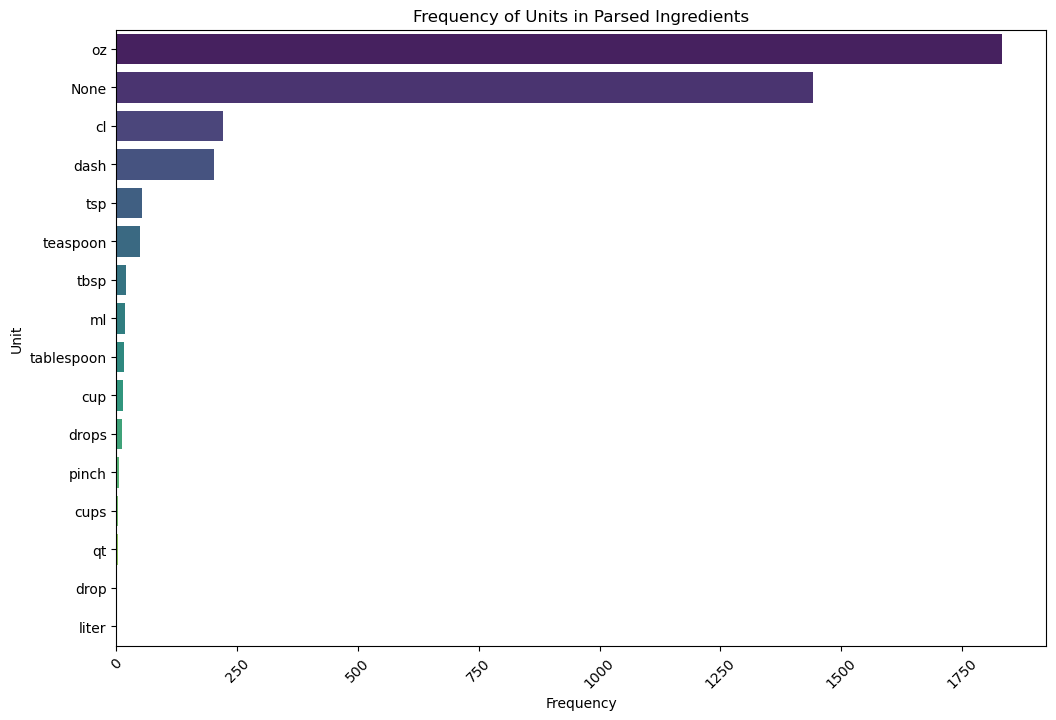

In [31]:
# Count the frequency of each unit, including None (NaN) values
unit_counts = parsed_df['unit'].value_counts(dropna=False)

# replace NaN (None) with a string for visualization purposes:
unit_counts.index = unit_counts.index.fillna('None')

# Create a bar chart
plt.figure(figsize=(12, 8))  
sns.barplot(x=unit_counts.values, y=unit_counts.index, palette="viridis", orient='h')  # Use horizontal bars

plt.title('Frequency of Units in Parsed Ingredients')
plt.ylabel('Unit')  # For horizontal bars, the y-axis now represents units
plt.xlabel('Frequency')
plt.xticks(rotation=45) 

plt.show()

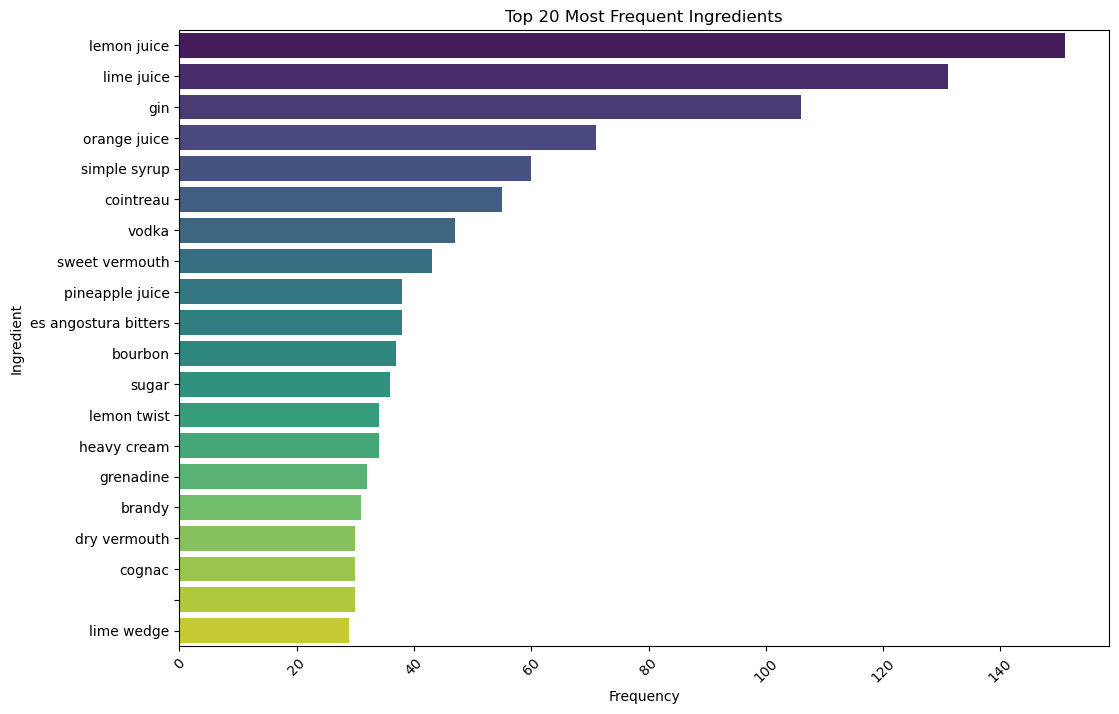

In [32]:
# Sort the dataframe by ingredient frequency (descending)
top_20_ingredients = parsed_df.groupby('ingredient')['ingredient'].count().sort_values(ascending=False).head(20)

# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_ingredients.values, y=top_20_ingredients.index, palette="viridis", orient='h')

plt.title('Top 20 Most Frequent Ingredients')
plt.ylabel('Ingredient')  # Label for horizontal bars
plt.xlabel('Frequency')
plt.xticks(rotation=45)

plt.show()

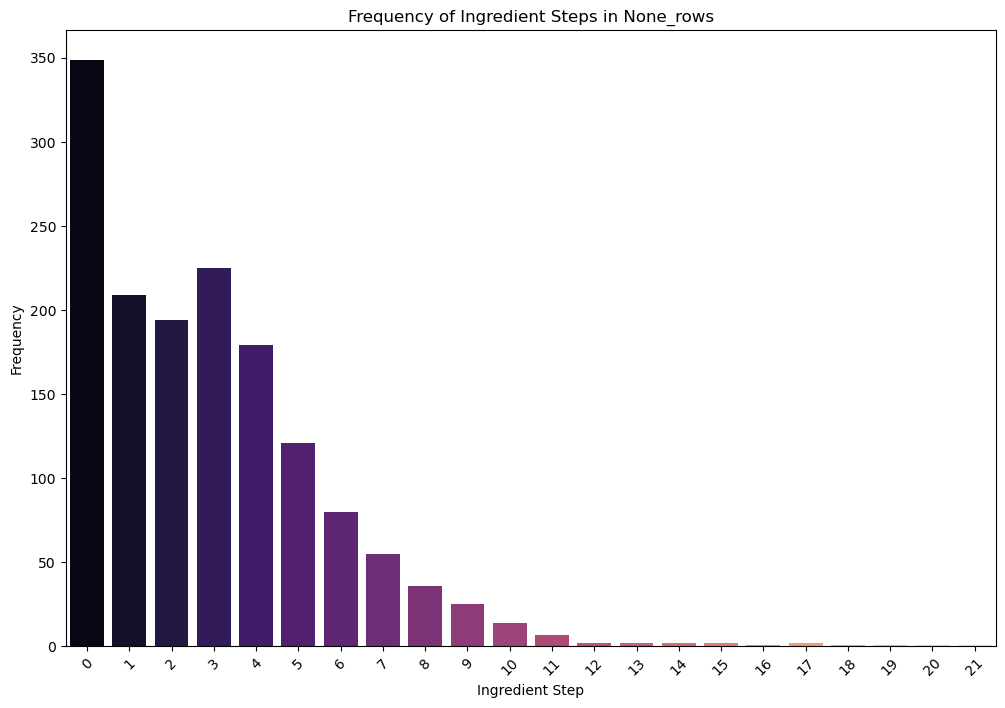

In [33]:
# Count the frequency of each ingredient_step
step_counts = none_rows['ingredient_step'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=step_counts.index, y=step_counts.values, palette="magma")  # Use vertical bars for steps

plt.title('Frequency of Ingredient Steps in None_rows')
plt.xlabel('Ingredient Step')  # For vertical bars, the x-axis represents ingredient steps
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

~350 in 0